# SIMPLE RNN

In [11]:
# Import standard libraries
import numpy as np  # For numerical operations and array handling
import pandas as pd  # For CSV file data processing and manipulation

# Explore the contents of the Kaggle input directory
# This will print all filenames under '/kaggle/input', where uploaded datasets are stored
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [12]:
# Check for GPU
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.18.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [13]:
# Import compatibility feature for consistent print
from __future__ import print_function

# Import layers and model building tools from TensorFlow
from tensorflow.keras.layers import Dense, Activation, SimpleRNN, Embedding  # Layers for the model
from tensorflow.keras.models import Sequential  # Used to build a sequential stack of layers (our RNN model)


In [14]:
%ls

sample_data/


In [15]:
# Open the Alice in Wonderland text file in binary mode ('rb') from the Kaggle input directory
fin = open("sample_data/alice.txt", 'rb')

lines = []
for line in fin:
    # Remove leading/trailing whitespace and convert to lowercase
    line = line.strip().lower()

    # Decode binary to ASCII, ignoring characters that can't be decoded
    line = line.decode("ascii", "ignore")

    # Skip empty lines
    if len(line) == 0:
        continue

    # Add the cleaned line to our list
    lines.append(line)

# Close the file after reading
fin.close()

# Combine all lines into a single text string
text = " ".join(lines)


In [16]:
# Step 1: Extract the unique set of characters in the text
chars = set(text)  # All unique characters that appear in the dataset

# Step 2: Count the total number of unique characters (vocabulary size)
nb_chars = len(chars)
print(f"Total unique characters (vocab size): {nb_chars}")

# Step 3: Create lookup dictionaries similar to tokenizing the data per character
# char2index: maps each character to a unique index
# index2char: maps each index back to its character
char2index = {c: i for i, c in enumerate(chars)}
index2char = {i: c for i, c in enumerate(chars)}


Total unique characters (vocab size): 45


In [17]:
# Length of each input sequence (number of characters the RNN will read before predicting the next one)
SEQLEN = 10

# Step size — how much to shift the window to get the next training example
STEP = 1

# Lists to hold input sequences and their corresponding next characters
input_chars = []
label_chars = []

# Slide a window of length SEQLEN across the text
for i in range(0, len(text) - SEQLEN, STEP):
    # Input: sequence of SEQLEN characters
    input_chars.append(text[i:i + SEQLEN])

    # Label: the character immediately following the sequence
    label_chars.append(text[i + SEQLEN])


In [18]:
# Initialize input array X:
# - Shape: (number of sequences, sequence length)
# - Each element will hold an integer index corresponding to a character
X = np.zeros((len(input_chars), SEQLEN), dtype=np.int32)

# Initialize output array y:
# - Shape: (number of sequences,)
# - Each element is the index of the next character to be predicted
y = np.zeros(len(input_chars), dtype=np.int32)

# Convert each character in the input sequences to its corresponding index
for i, input_seq in enumerate(input_chars):
    for j, ch in enumerate(input_seq):
        X[i, j] = char2index[ch]  # Fill in character index at position j

    # Set the target label as the index of the next character after the sequence
    y[i] = char2index[label_chars[i]]


In [19]:
# Hyperparameters
HIDDEN_SIZE = 128                # Number of units in the RNN hidden layer
BATCH_SIZE = 128                 # Number of samples per training batch
NUM_ITERATIONS = 25              # Total training iterations (outer loop)
NUM_EPOCHS_PER_ITERATION = 1     # Number of epochs per iteration
NUM_PREDS_PER_EPOCH = 100        # Number of characters to generate after each iteration

# Define a simple RNN model
model = Sequential()

# Embedding layer: maps input character indices to dense vectors
# input_dim = vocabulary size (number of unique characters)
# output_dim = embedding dimension (can be tuned)
# input_length = number of characters in each input sequence
model.add(Embedding(input_dim=nb_chars, output_dim=64, input_length=SEQLEN))

# Add the SimpleRNN layer
model.add(SimpleRNN(
    HIDDEN_SIZE,
    return_sequences=False,          # We only want the final output for prediction
    input_shape=(SEQLEN, nb_chars),  # Input shape: (sequence length, vocab size)
    unroll=True                      # Unroll the loop for speed which is useful for small sequences
))

# Fully connected output layer that predicts the next character
model.add(Dense(nb_chars))

# Softmax activation to output probability distribution over characters
model.add(Activation("softmax"))

# Compile the model with sparse categorical crossentropy loss and RMSprop optimizer
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="rmsprop"
)


In [20]:
# Initialize an empty list to store training loss values after each epoch
losses = []

# Training and generation loop
for iteration in range(NUM_ITERATIONS):
    print("=" * 50)
    print(f"Iteration #: {iteration}")

    # Train and save loss in history
    history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)

    # Append the training loss for this epoch to loss history list
    losses.extend(history.history["loss"])

    # Select a random seed sequence from training data
    test_idx = np.random.randint(len(input_chars))
    test_chars = input_chars[test_idx]

    print(f"\nGenerating from seed: \"{test_chars}\"")
    print(test_chars, end="")

    # Generate NUM_PREDS_PER_EPOCH characters from the seed
    for i in range(NUM_PREDS_PER_EPOCH):
        # Create a new test input array with shape (1, SEQLEN), containing integer indices
        Xtest = np.zeros((1, SEQLEN), dtype=np.int32)

        for j, ch in enumerate(test_chars):
            Xtest[0, j] = char2index[ch]  # Integer encode each character


        # Predict next character probabilities
        pred = model.predict(Xtest, verbose=0)[0]

        # Pick the most probable next character
        ypred = index2char[np.argmax(pred)]

        # Print the predicted character
        print(ypred, end="")

        # Slide the window: remove first char and append the predicted one
        test_chars = test_chars[1:] + ypred

print()  # Print newline after final output


Iteration #: 0
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 2.5351

Generating from seed: "soon finis"
soon finis alice and the har alice and the har alice and the har alice and the har alice and the har alice and==================================================
Iteration #: 1
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.9450

Generating from seed: " imitated "
 imitated and the hare all the hat and the hare all the hat and the hare all the hat and the hare all the hat ==================================================
Iteration #: 2
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.7665

Generating from seed: "the royal "
the royal said the mock turtle said the mock turtle said the mock turtle said the mock turtle said the mock tu==================================================
Iteration #: 3
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.6587

Generating from seed: "the roof o"
the roof of the mouse of the mouse of the mouse of the mouse of the mouse of the

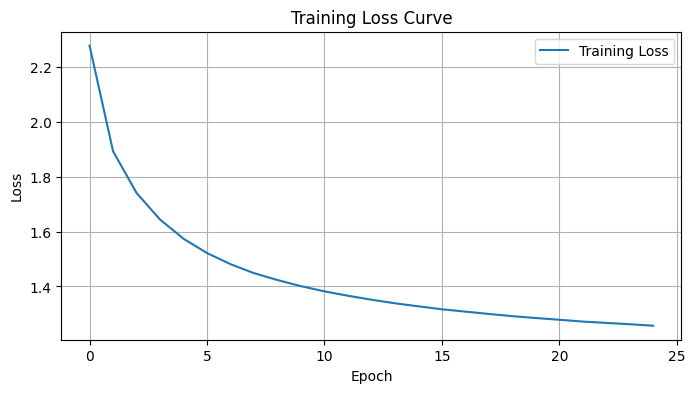

In [21]:
# Import the plotting library for visualizing training progress
import matplotlib.pyplot as plt

# Create a new figure with a custom size
plt.figure(figsize=(8, 4))

# Plot the training loss values stored in the 'losses' list
plt.plot(losses, label="Training Loss")

# Add title and axis labels
plt.title("Training Loss Curve")      # Title for the plot
plt.xlabel("Epoch")                   # X-axis shows training epochs
plt.ylabel("Loss")                    # Y-axis shows loss value

# Add legend and grid for better readability
plt.legend()                          # Show legend for the loss line
plt.grid(True)                        # Display grid lines for better readability

# Display the plot
plt.show()


# RNN Source: https://www.kaggle.com/code/roblexnana/generating-text-for-nlp-using-simplernn-with

This notebook provided a clear, working example of a character-level language model using Keras' SimpleRNN and Embedding layers. It helped me understand how to preprocess text into fixed-length sequences, build a simple RNN model, and generate text from a trained model. The structure of the notebook also closely aligns with the assignment, making it a great reference for my implementation.



#RNN Source: https://www.kaggle.com/code/paultimothymooney/text-generation-with-rnn-and-keras-bob-dylan

This souce helped me switch from one-hot encoding input to a more efficent representation by switching to "interger-encoded input" and introducing the embedded layer, I enabled the model to learn a dense vector representation for each charracter during training, further improving the models ablilty to recongize patterns in character sequences. This source also helped me update my loss function to sparse_categorecal_crossentropy.



#GRU GENERATION

In [22]:
# Import GRU layer from Keras
# GRU (Gated Recurrent Unit) is a more advanced RNN variant that helps retain long-term dependencies
from tensorflow.keras.layers import GRU


In [23]:
# Define a character-level language model using a GRU layer
gru_model = Sequential()

# Embedding layer: maps character indices to dense 64-dimensional vectors
# This allows the model to learn a continuous representation of characters
gru_model.add(Embedding(input_dim=nb_chars, output_dim=64, input_length=SEQLEN))

# GRU layer: processes the input sequence and captures temporal dependencies
# HIDDEN_SIZE controls the number of units in the GRU cell
# unroll=True can improve speed for small sequences
gru_model.add(GRU(HIDDEN_SIZE, unroll=True))

# Output layer: maps GRU output to vocabulary size for next character prediction
gru_model.add(Dense(nb_chars))

# Softmax activation: converts output to probability distribution over characters
gru_model.add(Activation("softmax"))

# Compile the model with loss and optimizer
# 'sparse_categorical_crossentropy' is used because the target labels are integer-encoded
gru_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="rmsprop"
)


In [25]:
# Initialize a list to store loss values from GRU model
gru_losses = []

# Train the GRU model over multiple iterations
for iteration in range(NUM_ITERATIONS):
    print("=" * 50)
    print(f"GRU Iteration #: {iteration}")

    # Train the model for 1 epoch and record loss
    history = gru_model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)

    # Store training loss to compare with other models
    gru_losses.extend(history.history["loss"])

     # Select a random seed sequence from training data
    test_idx = np.random.randint(len(input_chars))
    test_chars = input_chars[test_idx]

    print(f"\nGenerating from seed: \"{test_chars}\"")
    print(test_chars, end="")

    # Generate NUM_PREDS_PER_EPOCH characters from the seed
    for i in range(NUM_PREDS_PER_EPOCH):
        # Create a new test input array with shape (1, SEQLEN), containing integer indices
        Xtest = np.zeros((1, SEQLEN), dtype=np.int32)

        for j, ch in enumerate(test_chars):
            Xtest[0, j] = char2index[ch]  # Integer encode each character


        # Predict next character probabilities
        pred = model.predict(Xtest, verbose=0)[0]

        # Pick the most probable next character
        ypred = index2char[np.argmax(pred)]

        # Print the predicted character
        print(ypred, end="")

        # Slide the window: remove first char and append the predicted one
        test_chars = test_chars[1:] + ypred

print()  # Print newline after final output





GRU Iteration #: 0
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.4288

Generating from seed: "the twinkl"
the twinkle, then the mock turtle shouted the dormouse did not a bothout on the window, and the mock turtle sh==================================================
GRU Iteration #: 1
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.3742

Generating from seed: " of tumbli"
 of tumbling the dormouse did not a bothout on the window, and the mock turtle shouted the dormouse did not a ==================================================
GRU Iteration #: 2
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.3334

Generating from seed: " on their "
 on their face, and the mock turtle shouted the dormouse did not a bothout on the window, and the mock turtle ==================================================
GRU Iteration #: 3
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.2879

Generating from seed: "and that m"
and that make a little one eash the white rabbit began to the cat

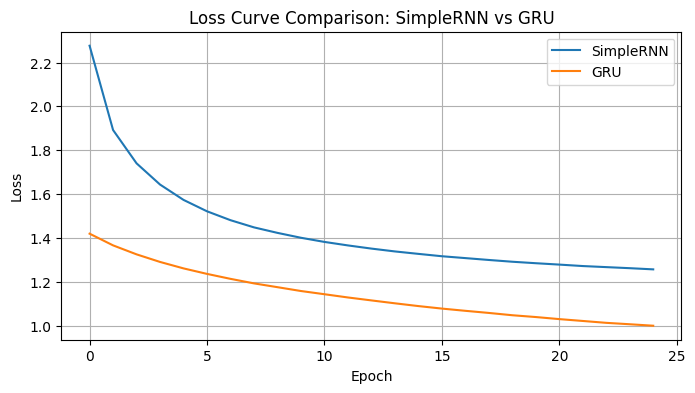

In [27]:
# Plot loss curves for both SimpleRNN and GRU models

# Create a figure with defined size

plt.figure(figsize=(8, 4))
# Plot training loss for each model
plt.plot(losses, label="SimpleRNN")
plt.plot(gru_losses, label="GRU")

# Add title and axis labels
plt.title("Loss Curve Comparison: SimpleRNN vs GRU")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Add legend to distinguish the curves
plt.legend()

# Add grid for better readability
plt.grid(True)

# Display the plot
plt.show()


# GRU SOURCE:https://www.kaggle.com/code/utkarshsaxenadn/text-generation-with-gru-cells-explained-code

This source helped me understand how to implement a GRU-based models. While the original notebook defines a particular model, I adapted the core GRU structure to fit within the framework of my existing character-level RNN model. This allows for a direct comparison between the SimpleRNN and GRU models using consistent inputs, training conditions, and evaluation metrics.

# TRANSFORMER

In [50]:
import numpy as np
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers, ops  # `ops` is used for TensorFlow operations



In [38]:
from tensorflow.keras.layers import MultiHeadAttention, Dense, Dropout, LayerNormalization

# Defines a single Transformer encoder block with self-attention and feed-forward layers
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()

        # Multi-head self-attention layer
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)

        # Feed-forward network: two dense layers
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),  # Project to a higher dimension
            layers.Dense(embed_dim)                   # Return to original dimension
        ])

        # Layer normalizations for residual connections
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        # Dropout for regularization
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        # Self-attention + residual + normalization
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)

        # Feed-forward + residual + normalization
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)


In [39]:


# This layer combines both token embedding and position embedding
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()

        # Embedding layer to learn vector representations of tokens (characters in your case)
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)

        # Embedding layer to learn positional encodings (instead of fixed sinusoids)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # Get the actual sequence length from input tensor
        maxlen = ops.shape(x)[-1]

        # Create position indices [0, 1, 2, ..., maxlen - 1]
        positions = ops.arange(start=0, stop=maxlen, step=1)

        # Embed the positions and tokens separately
        positions = self.pos_emb(positions)
        x = self.token_emb(x)

        # Add token and position embeddings (element-wise addition)
        return x + positions


In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense

# Builds a full Transformer model using the functional Keras API
def build_transformer_model(seq_len, vocab_size, embed_dim=64, num_heads=2, ff_dim=128):
    # Define input shape (batch, sequence length)
    inputs = Input(shape=(seq_len,))

    # Step 1: Embedding layer to map character indices to vectors
    x = Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)

    # Step 2: Add fixed positional encodings
    x = PositionalEncoding(seq_len, embed_dim)(x)

    # Step 3: Apply Transformer encoder block (can be repeated)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)

    # Step 4: Predict the next character using the last timestep only
    x = Dense(vocab_size, activation='softmax')(x[:, -1, :])  # Output shape: (batch_size, vocab_size)

    # Final model: input -> Transformer -> prediction
    model = Model(inputs, x)

    # Compile the model for training
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    return model


In [47]:
from tensorflow.keras import layers, models

# Function to build the Transformer model using your custom layers
def build_transformer_model(seq_len, vocab_size, embed_dim=64, num_heads=2, ff_dim=128, dropout_rate=0.1):
    # Input is a sequence of integers (character indices)
    inputs = layers.Input(shape=(seq_len,))

    # Token + position embedding layer
    embedding_layer = TokenAndPositionEmbedding(seq_len, vocab_size, embed_dim)
    x = embedding_layer(inputs)

    # Transformer block (you can stack more later if desired)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)
    x = transformer_block(x)

    # Only keep the final time step’s output (predict next character)
    x = layers.Dense(vocab_size, activation="softmax")(x[:, -1, :])

    # Define model and compile with sparse categorical loss (for integer labels)
    model = models.Model(inputs=inputs, outputs=x)
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
    return model


In [51]:
# Build the Transformer model using defined sequence length and vocabulary size
# The model uses an embedding layer, positional encoding, transformer block, and output layer
transformer_model = build_transformer_model(SEQLEN, nb_chars)


# Initialize a list to store the training loss values at each iteration
transformer_losses = []

# Train the Transformer model for a specified number of outer iterations
for iteration in range(NUM_ITERATIONS):
    print("=" * 50)
    print(f"Transformer Iteration #: {iteration}")

    # Train the model for a single epoch on the training data
    # We use batch training with BATCH_SIZE samples per gradient update
    history = transformer_model.fit(X, y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS_PER_ITERATION)

    # Append the loss from this epoch to the loss list for plotting/comparison later
    transformer_losses.extend(history.history["loss"])

     # Select a random seed sequence from training data
    test_idx = np.random.randint(len(input_chars))
    test_chars = input_chars[test_idx]

    print(f"\nGenerating from seed: \"{test_chars}\"")
    print(test_chars, end="")

    # Generate NUM_PREDS_PER_EPOCH characters from the seed
    for i in range(NUM_PREDS_PER_EPOCH):
        # Create a new test input array with shape (1, SEQLEN), containing integer indices
        Xtest = np.zeros((1, SEQLEN), dtype=np.int32)

        for j, ch in enumerate(test_chars):
            Xtest[0, j] = char2index[ch]  # Integer encode each character


        # Predict next character probabilities
        pred = transformer_model.predict(Xtest, verbose=0)[0]

        # Pick the most probable next character
        ypred = index2char[np.argmax(pred)]

        # Print the predicted character
        print(ypred, end="")

        # Slide the window: remove first char and append the predicted one
        test_chars = test_chars[1:] + ypred

print()  # Print newline after final output


Transformer Iteration #: 0
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 2.3693

Generating from seed: "lice was s"
lice was she the the the the the the the the the the the the the the the the the the the the the the the the t==================================================
Transformer Iteration #: 1
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.8653

Generating from seed: "rply and v"
rply and very the was the was the was the was the was the was the was the was the was the was the was the was ==================================================
Transformer Iteration #: 2
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.7613

Generating from seed: "ime with o"
ime with of the said the said the said the said the said the said the said the said the said the said the said==================================================
Transformer Iteration #: 3
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.7135

Generating from seed: "ans--to--m"
ans--to--mouse the dormouse the 

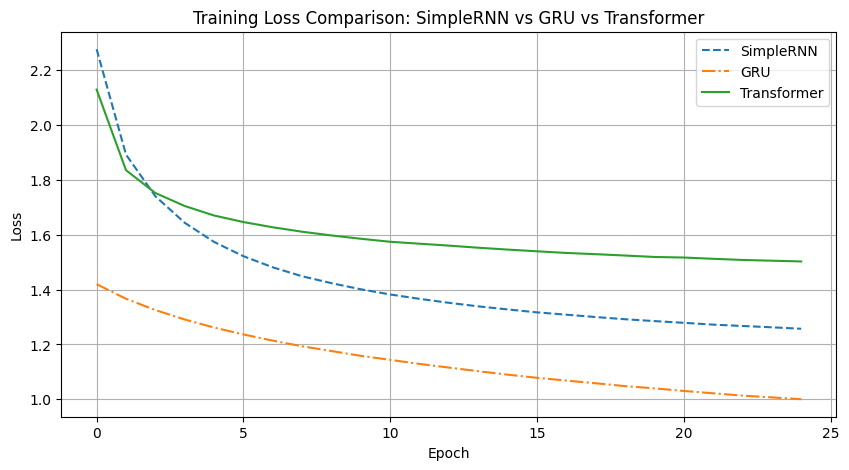

In [52]:
# Plot loss curves for all three, SimpleRNN and GRU and Transformer models
# This visual comparison helps evaluate which model learns more effectively

# Create a figure with defined size
plt.figure(figsize=(10, 5))

# Plot training loss for each model
plt.plot(losses, label="SimpleRNN", linestyle='--')
plt.plot(gru_losses, label="GRU", linestyle='-.')
plt.plot(transformer_losses, label="Transformer", linestyle='-')

# Add title and axis labels
plt.title("Training Loss Comparison: SimpleRNN vs GRU vs Transformer")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Add legend to distinguish the curves
plt.legend()

# Add grid for better readability
plt.grid(True)

# Display the plot
plt.show()

#CONCLUSIONS AND COMPARISONS



GRU (orange) consistently achieves the lowest loss throughout training. This is potentially due to its gating mechanism and memory efficiency.

SimpleRNN (blue) starts with high loss but shows steady improvement, though it plateaus earlier than the others as this is not an optimal method.

Transformer (green) starts strong and learns quickly early on but then flattens. This is expected in smaller Transformers without a lot of depth or large a dataset.

In this project, I trained three sequence-to-sequence models. A SimpleRNN, GRU, and a Transformer on a character-level language modeling task using the Alice in Wonderland dataset. Quantitatively, the GRU model achieved the lowest final training loss (approx. 1.0), followed by the Transformer (appox. 1.5) and then the SimpleRNN (approx. 1.3). This indicates that this particular GRU model learns more efficiently. We can attribute this to its gating mechanisms which help preserve relevant context over longer sequences. The Transformer started well seemed to converge quickly, but flattened out earlier than GRU due to limited model depth or a relatively small dataset. The SimpleRNN showed steady learning but plateaued sooner, reflecting its difficulty in capturing long-term dependencies.

Qualitatively, the text generated by the GRU was the most coherent, producing ledgeble character sequences and sometimes forming recognizable English words. The Transformer generated combinations and seemed to preserve stylistic patterns but also produced fragmented repeated or "stuttered" sequences. The SimpleRNN outputs also often repetitive highlighting its weaker ability to model complex dependencies. Overall, GRU provided the best tradeoff between training performance and generative quality in this task, while the Transformer showed potential with further tuning or scaling.

# Transformer Source: https://www.kaggle.com/code/bravesimba/implementing-transformers-for-text-generator

While adapting to its structure, I gained a deeper understanding of how Transformer models work in sequence modeling tasks. I learned how the positional encoding mechanism is used to inject order information into input embeddings, which is required since Transformers do not have recurrence. I also found that the multi-head self-attention layer’s role in allowing the model to weigh different parts of the input sequence when predicting the next token. Implementing the model also helped clarify the architectural flow: embedding to positional encoding to Transformer blocks to dense output. Compared to RNNs and GRUs, I saw how Transformers can process sequences in parallel and may require more data or tuning but are powerful modles overall. Unfortunatly this "Scratch" model does not perform as well as I believe so I switching to a second source.

# Transformer Source: https://keras.io/examples/nlp/text_classification_with_transformer/


This source provided a modular way to implement a Transformer instead of building it from scratch. I was able tonderstand how to use Keras' high-level layers like MultiHeadAttentionband Embedding to construct aTransformer block. The TransformerBlock and TokenAndPositionEmbedding, I adapted to my character-level language model for comparison agains the other two models. Overall, this source was key in helping me build a my current Transformer.